In [38]:
import warnings
import numpy as np
import pandas as pd
from scipy import sparse as sp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [39]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=3, linewidth=250)

### Loading Data set

In [40]:
x = np.loadtxt("../data/rin.dat")  #  data matrix

print("number of entities:", x.shape[0], ", number of features:", x.shape[1])

with open("../data/namrin", 'r') as fp:  # load names as list of string
    names_ = fp.readlines()

with open("../data/varrin", 'r') as fp:  # load features names as list of string
    features_ = fp.readlines()

number of entities: 91 , number of features: 5


### Creating Pandas DataFrame for Visualization


In [35]:
names = [name.strip() for name in names_]
features = [feature.strip().split(",")[0] for feature in features_]
# features

In [41]:
df = pd.DataFrame(data=x, columns=features[:-1], index=names[1:])
df.head()

,'Internet abonents,'Personal abon.,'Company abon.,'Mobile Int. user,'Volume of information
'Central',212.316,199.597,12.719,838.953,231.933
'Belgorod',248.517,236.956,11.558,963.444,361.539
'Bryansk',192.963,178.115,14.848,717.172,174.693
'Vladimir',155.780,145.530,10.250,649.882,202.636
'Voronezh',193.378,181.890,11.489,680.391,247.181


#####  Nominal Features

There are 8 names of larger entities consisting of regions following after them. These names are as follows:

1:Central including Russia (20 entities altogether),

2: NW+South

3: Volga+Ural

4: Sibir+Far East

Four parts in total

In [42]:
# parts_names = ["'Central'", "'NW'", "'South'", "'Volga'", "'Ural'", "'Sibir'", "'FarEast'"]
parts_names = ["'Central'", "'NW'", "'Volga'", "'Sibir'", ]

In [43]:
parts_indices = [names.index(pn)-1 for pn in parts_names]
parts_indices

[0, 19, 47, 67]

### Categorizing two features
We consider the first and the last features, that is Internet abonents and Volume of information

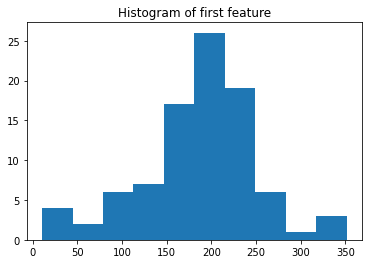

In [44]:
# number of bins is square root of number of entities in the data set
# range is (x.min(), x.max())
plt.hist(x[:, 0],int(np.round(np.sqrt(x.shape[0]))))
plt.title("Histogram of first feature")
plt.show()

boundaries for four categories of first feature : 

[0, 150, 210, 250, 350]


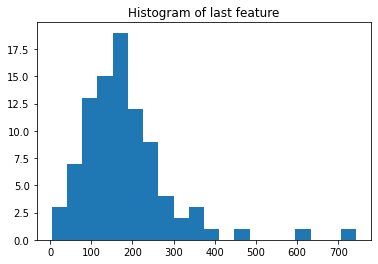

In [45]:
plt.hist(x[:, -1], bins=20)
plt.title("Histogram of last feature")
plt.show()

boundaries for categorization of last feature:

[0, 85, 200, 700]


### Part 1, Consider three nominal features 
one of them, not more, may be taken from nominal features in your data:

In [46]:
parts_indices

[0, 19, 47, 67]

In [47]:
,# categorize version of x; the last columns for nominal feature
x_c = np.zeros([x.shape[0], x.shape[1]+1])

for i in range(x_c.shape[0]):
    for v in range(x_c.shape[1]):
        if v == 0:
            if 0 <= x[i, v] < 150:
                x_c[i, v] = 1
            elif 150 <= x[i, v] < 210:
                x_c[i, v] = 2
            elif 210 <= x[i, v] < 250:
                x_c[i, v] = 3
            else:
                x_c[i, v] = 4
        if v == 4:
            if 0 <= x[i, v] < 85:
                x_c[i, v] = 1
            elif 85 <= x[i, v] < 200:
                x_c[i, v] = 2
            else:
                x_c[i, v] = 3
        if v == 5:
            if 0 <= i <= parts_indices[1]:
                x_c[i,v] = 1
            elif parts_indices[1] < i <= parts_indices[2]:
                x_c[i,v] = 2
            elif parts_indices[2] < i <= parts_indices[3]:
                x_c[i,v] = 3
            else:
                x_c[i,v] = 4         
        elif v!= 0 and v!=4 and v!=5:
            x_c[i,v] = x[i,v]

# G, H, T
# x_categorical = x_c[:, [0, 4, 5]]  
print(x_c.shape)

(91, 6)


So we created three nominal feature: 

- G-regions (4 categories),
- H-number of abonents grouped (4 categories), 
- T-volume grouped (3 categories)

### Part 2: Contingency Tables
##### Function for creating contingecy table

In [12]:
# def contingency_matrix(subset_1, subset_2):
    
#     """
#     A faster way to create a contingency table.
#     However this table is not intuitive
#     """
#     cat_1, cat_1_idx = np.unique(subset_1, return_invers,e=True)
#     cat_2, cat_2_idx = np.unique(subset_2, return_inverse=True)
#     n_cat_1 = cat_1.shape[0]
#     n_cat_2 = cat_2.shape[0]
#     # sp.coo_matrix:= A sparse matrix in COOrdinate format.
#     # Also known as the ‘ijv’ or ‘triplet’ format.
#     contingency = sp.coo_matrix((np.ones(cat_1_idx.shape[0]),
#                                 (cat_1_idx, cat_2_idx)),
#                                 shape=(n_cat_1, n_cat_2),
#                                 dtype=np.int)
    
#     contingency = contingency.toarray()
    
#     return contingency
    

In [49]:
def contingency_table(subset_1, subset_2):
    
    """
    An slower yet more intuitive way to create contingency table.
    returns contingency tables of two subsets,
    so that the last column and last row represent the
    marginal frequencies of Tk and Gl.
    """
    
    cat_1, cat_1_idx = np.unique(subset_1, return_inverse=True)
    cat_2, cat_2_idx = np.unique(subset_2, return_inverse=True)
    n_cat_1 = cat_1.shape[0]
    n_cat_2 = cat_2.shape[0]
    contingency = np.zeros([n_cat_1+1, n_cat_2+1], dtype=np.int)

    for row in range(n_cat_1):  
        for col in range(n_cat_2): 
            n_rc = len(set(np.where(cat_1_idx==row)[0].tolist()).intersection(
                    set(np.where(cat_2_idx==col)[0].tolist())))
            contingency[row, col] = n_rc
        contingency[row, -1] = np.sum(contingency[row, :])
    
    contingency[-1, :] = np.sum(contingency, axis=0)
    
    relative_frequencies = np.divide(contingency, contingency[-1, -1])
    
    return contingency, relative_frequencies

### Developing contingency tables P(T|G) and P(T|H):
######  P(T|G)

In [14]:
contingency_T_G, rel_freq_T_G = contingency_table(x_c[:, 4], x_c[:, 0])  # T given H

print("contingency P(T|G):", "\n",)
print(contingency_T_G)
print(" ")
print("prob P(T|G):", "\n",)
print(rel_freq_T_G)

contingency P(T|G): 

[[ 7  3  0  0 10]
 [12 23 12  1 48]
 [ 2 11 12  8 33]
 [21 37 24  9 91]]
 
prob P(T|G): 

[[0.077 0.033 0.    0.    0.11 ]
 [0.132 0.253 0.132 0.011 0.527]
 [0.022 0.121 0.132 0.088 0.363]
 [0.231 0.407 0.264 0.099 1.   ]]


###### P(H| T)

In [50]:
contingency_T_H, rel_freq_T_H = contingency_table(x_c[:, 4], x_c[:, 5])  # T given H
print("contingency P(T|H):", "\n",)
print(contingency_T_H)
print(" ")
print("prob P(T|H):", "\n",)
print(rel_freq_T_H)

contingency P(T|H): 

[[ 0  7  0  3 10]
 [10 16 14  8 48]
 [10  5  6 12 33]
 [20 28 20 23 91]]
 
prob P(T|H): 

[[0.    0.077 0.    0.033 0.11 ]
 [0.11  0.176 0.154 0.088 0.527]
 [0.11  0.055 0.066 0.132 0.363]
 [0.22  0.308 0.22  0.253 1.   ]]


In [16]:
# # marginal frequencies
# freq_of_G = np.sum(contingency_T_G, axis=0)  
# freq_of_T = np.sum(contingency_T_G, axis=1)
# freq_of_H = np.sum(contingency_T_G, axis=0) 
# print(freq_of_T.reshape(-1, 1),)
# print(" ")
# print(freq_of_G)


### Conditional Probabilities
##### marginal frequency
let us first introduce variables for tthe marginal frequencies

In [51]:
marg_freq_T = contingency_T_G[:-1, -1:]  # marginal frequencies of Ts
marg_freq_G = contingency_T_G[-1, :-1]  # marginal frequencies of Gs
marg_freq_H = contingency_T_H[-1, :-1]  # marginal frequencies of Hs

In [52]:
conditional_T_G = np.divide(contingency_T_G[:-1, :-1], marg_freq_G)
print("Conditional T given G:", "\n \n",
      conditional_T_G)

Conditional T given G: 
 
 [[0.333 0.081 0.    0.   ]
 [0.571 0.622 0.5   0.111]
 [0.095 0.297 0.5   0.889]]


 As one can see:

- T2 is more likely at G2,
- T3 is more likely at G4
- Only one number is high enough, p(T3|G4) = .889


In [54]:
conditional_T_H = np.divide(contingency_T_H[:-1, :-1], marg_freq_H)
print("Conditional T given H:", "\n \n",
      conditional_T_H)

Conditional T given H: 
 
 [[0.    0.25  0.    0.13 ]
 [0.5   0.571 0.7   0.348]
 [0.5   0.179 0.3   0.522]]


 As one can see:

- T2 is more likely at H3



### Quetelet (T|G)

#####  First way of computing Quetelet index 

In [22]:
quetelet_T_G = np.subtract(np.divide(conditional_T_G, 
                                     marg_freq_T/x.shape[0]), 1)
quetelet_T_G

array([[ 2.033, -0.262, -1.   , -1.   ],
       [ 0.083,  0.178, -0.052, -0.789],
       [-0.737, -0.18 ,  0.379,  1.451]])

##### Second way of computing Quetelet index 

In [23]:
# Independent probabilities: 
indep_T_n_G = marg_freq_T/x.shape[0]@marg_freq_G.reshape(1, -1)/x.shape[0]
indep_T_n_H = marg_freq_T/x.shape[0]@marg_freq_H.reshape(1, -1)/x.shape[0]


In [55]:
# Quetelet Index:
quetelet_T_G_ = np.subtract(np.divide(rel_freq_T_G[:-1, :-1], indep_T_n_G), 1)
quetelet_T_G_

array([[ 2.033, -0.262, -1.   , -1.   ],
       [ 0.083,  0.178, -0.052, -0.789],
       [-0.737, -0.18 ,  0.379,  1.451]])

- Note the identical results obtained by applying two ways for computing Quetelet index tabel

- Big positive numbers q(T1 | G1) = 203% and q(T3|G4) = 145% these are the relative increases of the probabilities.



In [56]:
# quetelet_T_G = np.subtract(np.divide(conditional_T_G, 
#                                      marg_freq_T/x.shape[0]), 1)

In [57]:
quetelet_T_H = np.subtract(np.divide(conditional_T_H, marg_freq_T/x.shape[0]), 1)
quetelet_T_H

array([[-1.   ,  1.275, -1.   ,  0.187],
       [-0.052,  0.083,  0.327, -0.341],
       [ 0.379, -0.508, -0.173,  0.439]])

In [58]:
quetelet_T_H_ = np.subtract(np.divide(rel_freq_T_H[:-1, :-1], indep_T_n_H), 1)
quetelet_T_H_

array([[-1.   ,  1.275, -1.   ,  0.187],
       [-0.052,  0.083,  0.327, -0.341],
       [ 0.379, -0.508, -0.173,  0.439]])

- Relatively big positive number q(T1 | H2) = 127% this is the relative increases of the probabilities still smaller than in the previous table.

### Part 3 Average Quetelet and Chi-squared 


In [59]:
def compute_chi2 (rel_freq, indep_prob):
    "As per slides page 50"
    d = np.subtract(rel_freq[:-1, :-1], indep_prob)
    dd = np.power(d, 2)
    chi =  np.divide(dd, indep_T_n_G)
    chi2 = np.sum(chi)
    return chi2

In [60]:
# Average Quetelet index is the inner product of two matrices:
# Observed relative contingency table and the table of Quetelet indices

ave_quet_idx_T_G = np.sum(rel_freq_T_G[:-1, :-1].reshape(1, -1)* 
                          quetelet_T_G.reshape(1, -1))

print("average Quetelet Index T given G:", ave_quet_idx_T_G)

average Quetelet Index T give G: 0.32786747786747783


In [64]:
chi2_T_G = compute_chi2(rel_freq_T_G, indep_T_n_G)
print("Chi2:", ave_quet_idx_T_G)

Chi2: 0.32786747786747783


- Meaning of the average Quetelet: on average, knowledge of Gl categories “adds” 32.8% to the frequency of Tk categories


- Chi-squared: Degree of Freedom is 6 = (3-1) *(4-1)

According to the table reported:

http://uregina.ca/~gingrich/appchi.pdf

- under the hypothesis of independence, the 95% confidence that N*chi-squared is less than t=12.592

We have N > 12.592/.328 = 38.4, that is, at any N>39 the hypothesis of statistical independence should be rejected at 95% confidence level.

Similarly, 

- at the 99% probability that chi-squared is less than t = 22.458

We have N > 22.458/.328 = 68.5, that is, at any N>69 the hypothesis of statistical independence should be rejected at 99% confidence level.

In our case $N=91$.


In [65]:
# Average Quetelet index is the inner product of two matrices:
# Observed relative contingency table and the table of Quetelet indices

ave_quet_idx_T_H = np.sum(rel_freq_T_H[:-1, :-1].reshape(1, -1)* 
                          quetelet_T_H.reshape(1, -1))

print("average Quetelet Index T given H:", ave_quet_idx_T_H)

average Quetelet Index T given H: 0.19375117635987196


In [66]:
chi2_T_H = compute_chi2(rel_freq_T_H, indep_T_n_H)
print("Chi2:", ave_quet_idx_T_H)

Chi2: 0.19375117635987196


- The Average Quetelet indexes show that association between G and T is twice larger than association between H and T. 



### The hypothesis of independence 

According to the table reported:

http://uregina.ca/~gingrich/appchi.pdf

- under the hypothesis of independence, the 95% confidence that N*chi-squared is less than t=12.592

We have N > 12.592/.193 = 65.2, that is, at any N>66 the hypothesis
of statistical independence should be rejected at 95% confidence level.

Similarly, 

- at the 99% probability that chi-squared is less than t = 22.458

N=91, we have N < 22.458/.193 = 116.4, that is, at any N<117 the hypothesis
of statistical independence should be accepted at 99% confidence level.
In our case $N=91$.  

At 95% confidence independence is rejected, at 99% confidence independence is accepted.


### Visualization

In [81]:
heat_map_quet_T_G = (rel_freq_T_G[:-1, :-1].reshape(1, -1)*quetelet_T_G.reshape(1, -1)).reshape(3, 4)

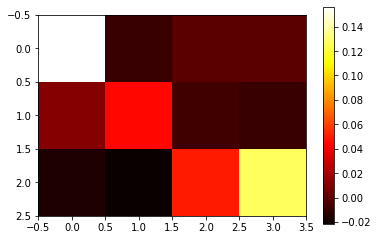

In [86]:
plt.imshow(heat_map_quet_T_G, cmap='hot', 
           interpolation='nearest')
plt.colorbar()
plt.show()

In [87]:
heat_map_quet_T_G

array([[ 0.156, -0.009, -0.   , -0.   ],
       [ 0.011,  0.045, -0.007, -0.009],
       [-0.016, -0.022,  0.05 ,  0.128]])

In [88]:
heat_map_quet_T_H = (rel_freq_T_H[:-1, :-1].reshape(1, -1)*quetelet_T_H.reshape(1, -1)).reshape(3, 4)
heat_map_quet_T_H

array([[-0.   ,  0.098, -0.   ,  0.006],
       [-0.006,  0.015,  0.05 , -0.03 ],
       [ 0.042, -0.028, -0.011,  0.058]])

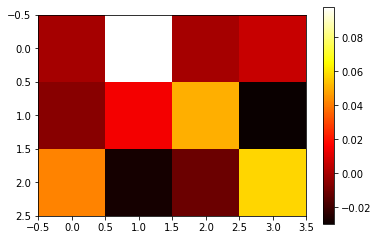

In [89]:
plt.imshow(heat_map_quet_T_H, cmap='hot', 
           interpolation='nearest')
plt.colorbar()
plt.show()